<a href="https://colab.research.google.com/github/Christian-VH-99/TP3-SOA/blob/main/Cuaderno_1_grupo2_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Introducción**

En el siguiente cuaderno se desarrolla el filtro "BoxBlur" en una imagen parametrizada, implementado en lenguaje Python de 2 maneras. Primero se vera la la ejecucion en forma secuencial usando solo CPU y luego se vera una implementacion en forma paralela con CUDA.

Al hablar del procesamiento de imágenes, una imagen generalmente es una matriz de dos dimensiones o incluso tres, y el kernel de convolución o filtro es una matriz mas chica que se utiliza cuando se realizan operaciones de convolución o relacionadas a una imagen. El filtro BoxBlur es un filtro de desenfoque, de convolución de una imagen, el cual se suele utilizar para eliminar o reducir el ruido en las imágenes. En este filtro el kernel que se utiliza es una matriz de 3x3, donde cada pixel de la imagen resultante tiene como valor el promedio de sus pixeles vecinos en la imagen original, logrando así un difuminado.

# **2. Armado del ambiente**



# 2.1 Selección de imagen
Para la poder llevar a cabo el ejercicio tomaremos la direccion web de una imagen con acceso publico a internet, la cual quedara disponible al contexto de ejecucion del cuaderno Colab.

In [2]:
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://github.com/Christian-VH-99/TP3-SOA/blob/main/Imagenes/imagen05.jpg?raw=true" #@param {type:"string"}
#@markdown ---
!wget {url_imagen} -O imagen.jpg

--2021-11-23 03:46:17--  https://github.com/Christian-VH-99/TP3-SOA/blob/main/Imagenes/imagen05.jpg?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Christian-VH-99/TP3-SOA/raw/main/Imagenes/imagen05.jpg [following]
--2021-11-23 03:46:17--  https://github.com/Christian-VH-99/TP3-SOA/raw/main/Imagenes/imagen05.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Christian-VH-99/TP3-SOA/main/Imagenes/imagen05.jpg [following]
--2021-11-23 03:46:17--  https://raw.githubusercontent.com/Christian-VH-99/TP3-SOA/main/Imagenes/imagen05.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443..

# 2.2 Instalación en el cuaderno el módulo CUDA de Python.

Para poder desarrollar el ejercicio en con CUDA para utilizar GPU y realizar paralelización necesitamos instalar el módulo de CUDA.

In [3]:
!pip install pycuda

     |████████████████████████████████| 1.7 MB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 75 kB 3.9 MB/s 
     |████████████████████████████████| 66 kB 3.9 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627448 sha256=d2339f94439854a517bed7d772efb064a9d9fe95c41400e00739ee9adeef3429
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.9-py2.py3-none-any.whl size=62370 sha256=eb38fd821d4765b7d0a3f5e05ad55e10f81803b7230fb728de35e4c3d6da9bd0
  Stored in directory: /root/.cache/pip/wheels/41/b9/6e/94bb014f6484b15ec77e7877f3a227609481ffd98db364504d
Successfully built pycuda pytools


# **3. Desarrollo en CPU**

A continuación se resuelve el ejercicio desde el punto de vista secuancial.

Imagen del filtro: imagen.jpg -RGB- [300, 300]
Tiempo de ejecución CPU:  3153.099 [ms]
Tiempo Total:  3237.716 [ms]


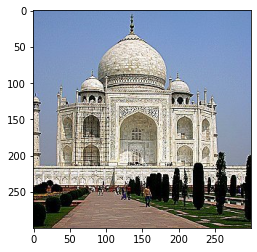

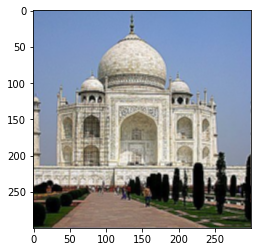

In [4]:
from datetime import datetime

tiempo_total_cpu = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_nombre = 'imagen.jpg'
image = Image.open(img_nombre)

# Obtengo las dimensiones de la imagen
img_ancho, img_alto = image.size

# Convierto la imagen comprimida en JPEG/PNG a array.
img_origen = numpy.asarray(image)
img_origen = img_origen.astype( numpy.int32() )

# Genero el array resultado (3 pixeles usa RGB * (el tamaño del array)).
img_resultado = numpy.empty_like( img_origen)

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

plt.figure()
imgplot=plt.imshow( img_origen )

tiempo_img_cpu = datetime.now()

# Convierto la imagen a escala de grises

for y  in range( 0, img_alto ):
  for x in range( 0, img_ancho ):
    r_prom=0
    g_prom=0
    b_prom=0

    pixel_R, pixel_G, pixel_B = img_origen[(y-1+img_alto)%img_alto][(x-1+img_ancho)%img_ancho]
    r_prom+=pixel_R
    g_prom+=pixel_G
    b_prom+=pixel_B
    
    pixel_R, pixel_G, pixel_B = img_origen[(y-1+img_alto)%img_alto][x]
    r_prom+=pixel_R
    g_prom+=pixel_G
    b_prom+=pixel_B

    pixel_R, pixel_G, pixel_B = img_origen[(y-1+img_alto)%img_alto][(x+1+img_ancho)%img_ancho]
    r_prom+=pixel_R
    g_prom+=pixel_G
    b_prom+=pixel_B

    pixel_R, pixel_G, pixel_B = img_origen[y][(x-1+img_ancho)%img_ancho]
    r_prom+=pixel_R
    g_prom+=pixel_G
    b_prom+=pixel_B

    pixel_R, pixel_G, pixel_B = img_origen[y][x]
    r_prom+=pixel_R
    g_prom+=pixel_G
    b_prom+=pixel_B

    pixel_R, pixel_G, pixel_B = img_origen[y][(x+1+img_ancho)%img_ancho]
    r_prom+=pixel_R
    g_prom+=pixel_G
    b_prom+=pixel_B

    pixel_R, pixel_G, pixel_B = img_origen[(y+1+img_alto)%img_alto][(x-1+img_ancho)%img_ancho]
    r_prom+=pixel_R
    g_prom+=pixel_G
    b_prom+=pixel_B

    pixel_R, pixel_G, pixel_B = img_origen[(y+1+img_alto)%img_alto][x]
    r_prom+=pixel_R
    g_prom+=pixel_G
    b_prom+=pixel_B

    pixel_R, pixel_G, pixel_B = img_origen[(y+1+img_alto)%img_alto][(x+1+img_ancho)%img_ancho]
    r_prom+=pixel_R
    g_prom+=pixel_G
    b_prom+=pixel_B

    rojo = int(r_prom/9)
    verde = int(g_prom/9)
    azul = int(b_prom/9)
    img_resultado[y][x] = [rojo,verde,azul]


tiempo_img_cpu = datetime.now() - tiempo_img_cpu

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot = plt.imshow( img_resultado )

tiempo_total_cpu = datetime.now() - tiempo_total_cpu

print( "Tiempo de ejecución CPU: ", tiempo_en_ms( tiempo_img_cpu   ), "[ms]" )
print( "Tiempo Total: ",            tiempo_en_ms( tiempo_total_cpu ), "[ms]" )

# **4. Desarrollo en GPU**

A continuación se reselve el ejercicio desde el punto de vista optimizado con CUDA.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: UserWarning: The CUDA compiler succeeded, but said the following:
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).



Imagen del filtro: imagen.jpg -RGB- [300, 300]
Thread: [ 16 , 19  ], Bloque : [ 19 , 16 ]
Total de Thread: [ 304 , 304  ]  =  92416
Tiempo de ejecución GPU:  1.951 [ms]
Tiempo Total:  1129.888 [ms]


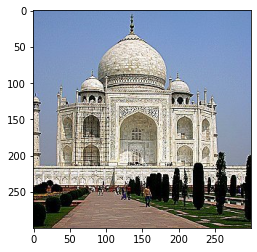

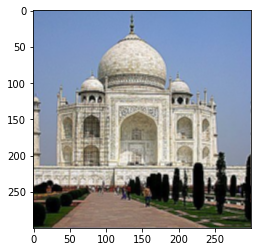

In [5]:
%matplotlib inline
from datetime import datetime
tiempo_total_gpu = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image
try: 
  import pycuda.driver as cuda
  import pycuda.autoinit
  from pycuda.compiler import SourceModule

  # --------------------------------------------
  # Definición de función que transforma el tiempo en  milisegundos 
  tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
  # --------------------------------------------

  img_nombre = 'imagen.jpg'
  image = Image.open( img_nombre ) 
    
  # summarize some details about the image 
  img_ancho, img_alto  = image.size 

  # Convierto la imagen comprimida en JPEG/PNG a array
  img_O_cpu = numpy.asarray(image)
  img_O_cpu = img_O_cpu.astype( numpy.int32() )
  img_R_cpu = numpy.empty_like( img_O_cpu)
  try:
    # Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
    img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
    img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

    # GPU - Copio la memoria al GPU.
    cuda.memcpy_htod( img_O_gpu, img_O_cpu )
    cuda.memcpy_htod( img_R_gpu, img_R_cpu )
  except Exception as e:
    print("No se pudo reservar memoria en GPU. ",e.args)

  # CPU - Defino la función kernel que ejecutará en GPU.
  module = SourceModule("""
  __global__ void kernel_img( int ancho, int alto, int *img_O, int *img_R )
  {
    // Calculo las coordenadas del Thread en dos dimensiones.
    int idx = threadIdx.x + blockIdx.x*blockDim.x;
    int idy = threadIdx.y + blockIdx.y*blockDim.y;
    
    int red;
    int green;
    int blue;

    int r_promedio;
    int g_promedio;
    int b_promedio;

    int x;
    int y;


    // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
    if( idx < ancho &&  idy < alto  )
    {

      red=0;
      green=0;
      blue=0;

      r_promedio=0;
      g_promedio=0;
      b_promedio=0;

      //obtengo los adyacentes
      x = idx;
      y = idy;

      red += img_O[( ((x-1+ancho)%ancho) + ( ((y-1+alto)%alto)*ancho) )*3 ];  // Componente Rojo del pixel.
      green += img_O[((((x-1+ancho)%ancho) + ( ((y-1+alto)%alto)*ancho))*3)+1];  // Componente Verde del pixel.
      blue += img_O[((((x-1+ancho)%ancho) + ( ((y-1+alto)%alto)*ancho))*3)+2];   // Componente Azul del pixel.

      red += img_O[( x + ( ((y-1+alto)%alto)*ancho) )*3 ];  // Componente Rojo del pixel.
      green += img_O[((x + ( ((y-1+alto)%alto)*ancho))*3)+1];  // Componente Verde del pixel.
      blue += img_O[((x + ( ((y-1+alto)%alto)*ancho))*3)+2];   // Componente Azul del pixel.

      red += img_O[( ((x+1+ancho)%ancho) + ( ((y-1+alto)%alto)*ancho) )*3 ];  // Componente Rojo del pixel.
      green += img_O[((((x+1+ancho)%ancho) + ( ((y-1+alto)%alto)*ancho))*3)+1];  // Componente Verde del pixel.
      blue += img_O[((((x+1+ancho)%ancho) + ( ((y-1+alto)%alto)*ancho))*3)+2];   // Componente Azul del pixel.

      red += img_O[( ((x-1+ancho)%ancho) + (idy*ancho) )*3 ];  // Componente Rojo del pixel.
      green += img_O[((((x-1+ancho)%ancho) + (idy*ancho))*3)+1];  // Componente Verde del pixel.
      blue += img_O[((((x-1+ancho)%ancho) + (idy*ancho))*3)+2];   // Componente Azul del pixel.
      
      red += img_O[( x + (idy*ancho))*3 ];  // Componente Rojo del pixel.
      green += img_O[((x + (idy*ancho))*3)+1];  // Componente Verde del pixel.
      blue += img_O[((x + (idy*ancho))*3)+2];   // Componente Azul del pixel.

      red += img_O[( ((x+1+ancho)%ancho) + (idy*ancho))*3 ];  // Componente Rojo del pixel.
      green += img_O[((((x+1+ancho)%ancho) + (idy*ancho))*3)+1];  // Componente Verde del pixel.
      blue += img_O[((((x+1+ancho)%ancho) + (idy*ancho))*3)+2];   // Componente Azul del pixel.

      red += img_O[( ((x-1+ancho)%ancho) + ( ((y+1+alto)%alto)*ancho) )*3 ];  // Componente Rojo del pixel.
      green += img_O[((((x-1+ancho)%ancho) + ( ((y+1+alto)%alto)*ancho))*3)+1];  // Componente Verde del pixel.
      blue += img_O[((((x-1+ancho)%ancho) + ( ((y+1+alto)%alto)*ancho))*3)+2];   // Componente Azul del pixel.

      red += img_O[(x + ( ((y+1+alto)%alto)*ancho) )*3 ];  // Componente Rojo del pixel.
      green += img_O[((x + ( ((y+1+alto)%alto)*ancho))*3)+1];  // Componente Verde del pixel.
      blue += img_O[((x + ( ((y+1+alto)%alto)*ancho))*3)+2];   // Componente Azul del pixel.

      red += img_O[( ((x+1+ancho)%ancho) + ( ((y+1+alto)%alto)*ancho) )*3 ];  // Componente Rojo del pixel.
      green += img_O[((((x+1+ancho)%ancho) + ( ((y+1+alto)%alto)*ancho))*3)+1];  // Componente Verde del pixel.
      blue += img_O[((((x+1+ancho)%ancho) + ( ((y+1+alto)%alto)*ancho))*3)+2];   // Componente Azul del pixel.


      r_promedio = red/9;
      g_promedio = green/9;
      b_promedio = blue/9;

      // Escribo el color del pixel.
      img_R[(idx+(idy*ancho))*3  ] = r_promedio;
      img_R[(idx+(idy*ancho))*3+1] = g_promedio;
      img_R[(idx+(idy*ancho))*3+2] = b_promedio;
    }
  }
  """) 

  # Muestro los atributos de la imagen y como se ve antes del seudo filtro.
  print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

  # CPU - Genero la función kernel.
  kernel = module.get_function("kernel_img")


  dim_hilo_x = 16
  dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

  dim_hilo_y = 19
  dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

  print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
  print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

  tiempo_img_gpu = datetime.now()

  kernel( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

  tiempo_img_gpu = datetime.now() - tiempo_img_gpu

  # GPU - Copio el resultado desde la memoria GPU.
  cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

  # Muestro la imagen Original el filtro.
  plt.figure()
  imgplot=plt.imshow( img_O_cpu )

  # Muestro la imagen luego de aplicarle el filtro.
  plt.figure()
  imgplot=plt.imshow( img_R_cpu )

  tiempo_total_gpu = datetime.now() - tiempo_total_gpu

  print("Tiempo de ejecución GPU: ", tiempo_en_ms( tiempo_img_gpu ), "[ms]" )
  print("Tiempo Total: ", tiempo_en_ms( tiempo_total_gpu ), "[ms]" )
except Exception as e:
  print("Recuerde conectarse a un entrono GPU y ejecutar el codigo para instalación del modulo CUDA.\n ",e.args)

# **5. Métricas**

Al ejecutar el codigo que resuelve el ejercicio con CPU (de forma secuencial) y al ejecutar el codigo que resuelve el ejercicio con GPU ( de forma paralela con CUDA) presentamos como salida algunas medidas, como ser el tiempo que se tarda en realizar el algoritmo que hace el filtro boxBlur o el tiempo total desde que se carga la imagen, se la convierte en array y se ejecuta el algoritmo. Si ejecutamos un par de veces cada algoritmo para la imagen05 disponible en el repositorio de git, podemos sacar un promedio de dichos tiempos:


> Desarrollo CPU:
- Tiempo promedio ejecución del algoritmo en CPU: *3161.282 ms*
- Tiempo promedio total en CPU:  *3203.446 ms*


> Desarrollo GPU:
- Tiempo promedio ejecución del algoritmo en GPU:  *0.106 ms*
- Tiempo promedio total en GPU:  *56.9528 ms*

También podemos obtener el **SpeedUp** que nos permite ver cuanto mas rápido es un algoritmo ejecutado en paralelo contra el algoritmo secuencial.
Al obtener el speedUp podemos obtener la **Eficiencia** obtenida, que es el tiempo en que los procesadores no estan "ociosos".

- #### *SpeedUp = TiempoSecuencial / TiempoParalelo*
- #### *Eficiencia = SpeedUp / Cant.Procesadores*


In [6]:
%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

diferencia_tiempos = tiempo_img_cpu-tiempo_img_gpu

print( "Tiempo de ejecución CPU: ", tiempo_en_ms( tiempo_img_cpu   ), "[ms]" )
print( "Tiempo Total: ",            tiempo_en_ms( tiempo_total_cpu ), "[ms]" )

print("------------------------------")

print("Tiempo de ejecución GPU: ", tiempo_en_ms( tiempo_img_gpu ), "[ms]" )
print("Tiempo Total: ",          tiempo_en_ms( tiempo_total_gpu ), "[ms]" )

print("------------------------------")

print("Diferencia de tiempos entre CPU y GPU: ",tiempo_en_ms( diferencia_tiempos ), "[ms]")

print("------------------------------")

print("SpeedUp: ", tiempo_en_ms(tiempo_total_cpu)/tiempo_en_ms(tiempo_total_gpu), "[ms]")
print("Eficiencia: ", (tiempo_en_ms(tiempo_total_cpu)/tiempo_en_ms(tiempo_total_gpu))/2, "[ms]" )

Tiempo de ejecución CPU:  3153.099 [ms]
Tiempo Total:  3237.716 [ms]
------------------------------
Tiempo de ejecución GPU:  1.951 [ms]
Tiempo Total:  1129.888 [ms]
------------------------------
Diferencia de tiempos entre CPU y GPU:  3151.148 [ms]
------------------------------
SpeedUp:  2.8655194143136313 [ms]
Eficiencia:  1.4327597071568157 [ms]


# **6. Conclusiones**

Bajo el contexto del procesamiento de imágenes digitales representadas en una matriz de dos dimensiones, cuando se aplica el algoritmo que genera el filtro Box Blur, como se puede ver en la sección anterior donde se comparan los tiempos que se tarda en la ejecución del algoritmo desde el punto de vista secuencial y desde la ejecucion en paralela con CUDA, queda en evidencia que hay una mejora en la performance.
Al acceder a cada pixel de la imagen de forma secuencial se tarda mucho mas que accediendo a varios pixeles simultaneamente con diferentes hilos, haciendo que estos realicen la misma operación pero claramente con diferentes datos, en este caso con difernetes pixeles. Esto lo podemos visualizar en la diferencia de tiempo que hay entre la ejecución de CPU y la de GPU.


# **7. Bibliografía**

[1] GPU-based image blur algorithms: [web](https://www.intel.com/content/www/us/en/developer/articles/technical/an-investigation-of-fast-real-time-gpu-based-image-blur-algorithms.html)

[2] Image Processing: Local Operators Local operators Convolutions Smooting and Bluring Edge detection Sharpening Non Linear filters: [PDF](
https://www.academia.edu/42067888/Image_Processing_Local_Operators_Local_operators_Convolutions_Smooting_and_Bluring_Edge_detection_Sharpening_Non_Linear_filters?source=swp_share)

[3] Procesamiento de imágenes, efectos de imagen mediante kernels y filtros convolucionales: [web](https://ichi.pro/es/procesamiento-de-imagenes-con-python-efectos-de-imagen-mediante-kernels-y-filtros-convolucionales-203995068082429)

[4] Blurring images: [web](https://datacarpentry.org/image-processing/06-blurring/)

[5] Image Blur Logic: [web](https://idmnyu.github.io/p5.js-image/Blur/index.html)

[6] Programación en CUDA: [PDF](https://riubu.ubu.es/bitstream/handle/10259/3933/Programacion_en_CUDA.pdf;jsessionid=61C8266327A60154227C8C6E009966E3?sequence=1)

